In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import tf_data
import tensorflow as tf
import mplhep as hep
plt.style.use(hep.style.CMS)

In [3]:
data_path = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v6/training/calo_matched/*.proto",
             #"gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/calo_matched/*.proto",
             #"ele_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/training/no_calo_matched/*.proto",
             #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/no_calo_matched/*.proto"
            }

In [9]:
# Load a balanced dataset from the list of paths given to the function. Selected only the requestes features from clusters and prepare batches
total_ds = tf_data.load_dataset_single(data_path["ele_match"],{"read_hits":True, "read_metadata":True}).shuffle(1000)

total_ds = total_ds.filter(lambda d1,d2:  d1["w_cl"]==2 and d1["n_cl"]> 7)



In [10]:
df = tf_data.get(total_ds)

In [11]:
df[0]

{'f': <tf.Tensor: shape=(), dtype=int64, numpy=11>,
 'n_cl': <tf.Tensor: shape=(), dtype=int64, numpy=10>,
 's_f': <tf.Tensor: shape=(22,), dtype=float32, numpy=
 array([1.2681507e+00, 1.4979157e+00, 7.3000000e+01, 9.6000000e+01,
        0.0000000e+00, 1.4464168e+02, 7.5420135e+01, 1.4616521e+02,
        7.6214546e+01, 9.5859927e-01, 7.9772333e-03, 1.1250031e-05,
        1.3448355e-02, 6.3616621e-01, 9.5859927e-01, 8.0148922e-03,
        1.1358534e-05, 1.3462091e-02, 6.3616621e-01, 5.0000000e+00,
        7.3021962e-03, 1.0917425e-02], dtype=float32)>,
 's_h': <tf.Tensor: shape=(18, 4), dtype=float32, numpy=
 array([[73.        , 96.        ,  0.        , 96.90379   ],
        [73.        , 97.        ,  0.        , 22.980831  ],
        [73.        , 98.        ,  0.        ,  2.6362855 ],
        [72.        , 98.        ,  0.        ,  0.57344687],
        [72.        , 97.        ,  0.        ,  1.294192  ],
        [72.        , 96.        ,  0.        ,  2.8982625 ],
        [72. 

In [5]:
seed_features = ["seed_eta","seed_phi", "seed_ieta","seed_iphi", "seed_iz", 
                     "en_seed", "et_seed","en_seed_calib","et_seed_calib",
                     "en_true","et_true",
                    "seed_f5_r9","seed_f5_sigmaIetaIeta", "seed_f5_sigmaIetaIphi",
                    "seed_f5_sigmaIphiIphi","seed_f5_swissCross",
                    "seed_r9","seed_sigmaIetaIeta", "seed_sigmaIetaIphi",
                    "seed_sigmaIphiIphi","seed_swissCross",
                    "seed_nxtals","seed_etaWidth","seed_phiWidth",
                    ]

In [12]:
def delta_iphi(phi1, phi2):
    dphi = phi1 - phi2
    mask_1 = dphi > 180
    mask_2 = dphi < 180
    dphi =  dphi - mask_1 * 2*180
    return dphi

import math
def delta_phi(phi1, phi2):
    dphi = phi1 - phi2
    mask_1 = dphi > math.pi
    mask_2 = dphi < math.pi
    dphi =  dphi - mask_1 * math.pi
    return dphi


def delta_eta(ieta_seed, ieta):
    if (ieta_seed >0):
        return ieta - ieta_seed
    else:
        return ieta_seed - ieta
    return deta

In [13]:
df = tf_data.get(total_ds)

In [14]:
cl_f = df[1]["cl_f"].numpy()
seed_f = df[0]["s_f"].numpy()

deta = cl_f[:,3]
dphi =  cl_f[:,4]

ncl = df[0]["n_cl"]

dphi_range = np.max(np.abs(dphi))
deta_range = np.max(np.abs(deta))

size = cl_f[:,6]*20

in_sc = df[1]["cl_l"][:,3].numpy()
in_mustache = df[1]["cl_l"][:,4].numpy()

colors_insc = list(map(lambda a:  "#16ab3e" if a else "#f2422e" , in_sc))
colors_inmust = list(map(lambda a:  "#422ef2" if a else "#f2422e" , in_mustache))

W0422 16:12:36.099499 140086160365376 font_manager.py:1357] findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary '))

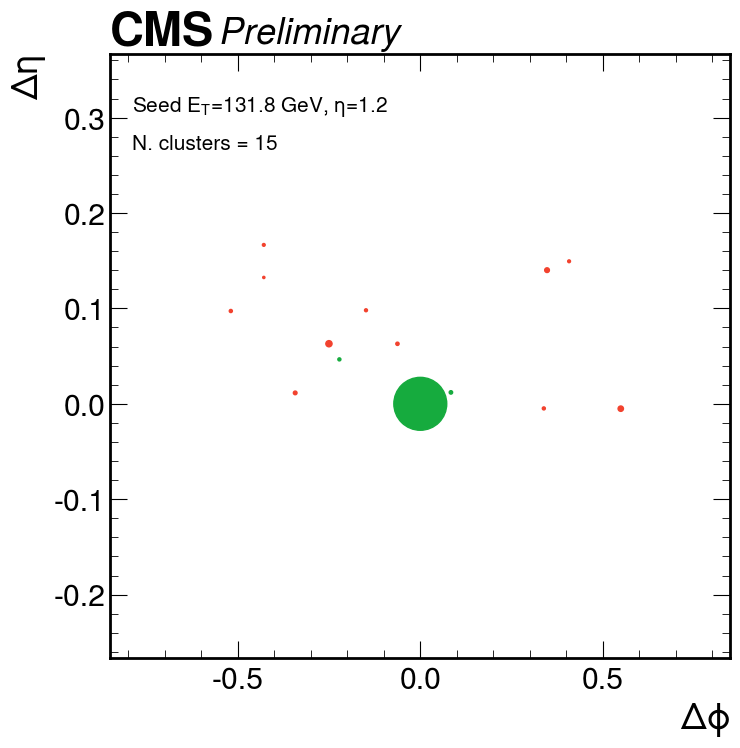

In [15]:
f, ax = plt.subplots(1,1,dpi=100, figsize=(8,8))
scatter = ax.scatter(dphi,deta, s=size, c=colors_insc)
ax.set_xlim(-dphi_range-0.3 , dphi_range+0.3)
ax.set_ylim(-deta_range-0.1 , deta_range+0.2)
ax.text(-dphi_range-0.24, +deta_range+0.14,"Seed $E_T$={:.1f} GeV, $\eta$={:.1f}".format(seed_f[7],seed_f[0]), fontsize="xx-small")
ax.text(-dphi_range-0.24, +deta_range+0.10,"N. clusters = {}".format(ncl), fontsize="xx-small")
ax.set_xlabel("$\Delta\phi$")
ax.set_ylabel("$\Delta\eta$")
# legend1 = ax.legend(*scatter.legend_elements(),
#                     title="In supercluster",  bbox_to_anchor=(0.6, 0.9,0.01,0.01))
# ax.add_artist(legend1)

hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary '))

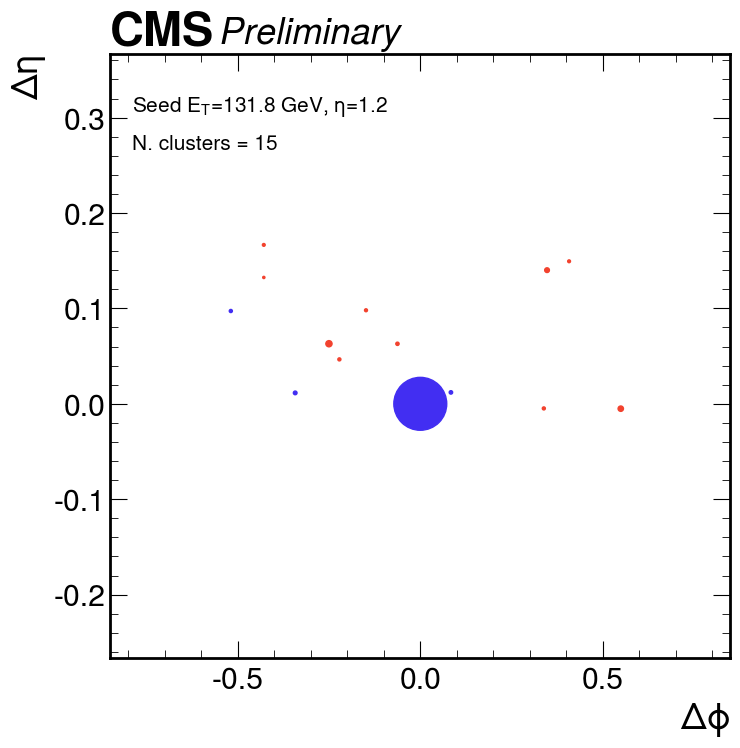

In [16]:
f, ax = plt.subplots(1,1,dpi=100, figsize=(8,8))
ax.scatter(dphi,deta, s=size, c=colors_inmust)
ax.set_xlim(-dphi_range-0.3 , dphi_range+0.3)
ax.set_ylim(-deta_range-0.1 , deta_range+0.2)
ax.text(-dphi_range-0.24, +deta_range+0.14,"Seed $E_T$={:.1f} GeV, $\eta$={:.1f}".format(seed_f[7],seed_f[0]), fontsize="xx-small")
ax.text(-dphi_range-0.24, +deta_range+0.10,"N. clusters = {}".format(ncl), fontsize="xx-small")
ax.set_xlabel("$\Delta\phi$")
ax.set_ylabel("$\Delta\eta$")

hep.cms.text("Preliminary ",loc=0)

In [17]:
df[1]["cl_h"][:,:,1].flat_values

<tf.Tensor: shape=(56,), dtype=float32, numpy=
array([271., 272., 273., 273., 272., 271., 270., 269., 268., 267., 267.,
       269., 270., 270., 271., 272., 270., 271., 272., 273., 271., 270.,
       269., 268., 267., 267., 268., 269., 270., 270., 271., 270., 271.,
       272., 286., 285., 240., 251., 252., 291., 275., 269., 268., 267.,
       266., 267., 269., 270., 301., 252., 285., 284., 280., 248., 296.,
       296.], dtype=float32)>

In [18]:
if seed_f[4] == 0  
 

SyntaxError: invalid syntax (<ipython-input-18-5a115fe54cc2>, line 1)

In [19]:
idphi = delta_iphi( seed_f[3], cl_f[:,1])
ideta = delta_eta(seed_f[2],cl_f[:,0])

rechit_en = df[1]["cl_h"][:,:,3].flat_values.numpy()
rechit_ieta = df[1]["cl_h"][:,:,0].flat_values.numpy()

if seed_f[2] < 0:
    rechit_ieta *= -1

rechit_iphi = delta_iphi(seed_f[3], df[1]["cl_h"][:,:,1].flat_values.numpy())

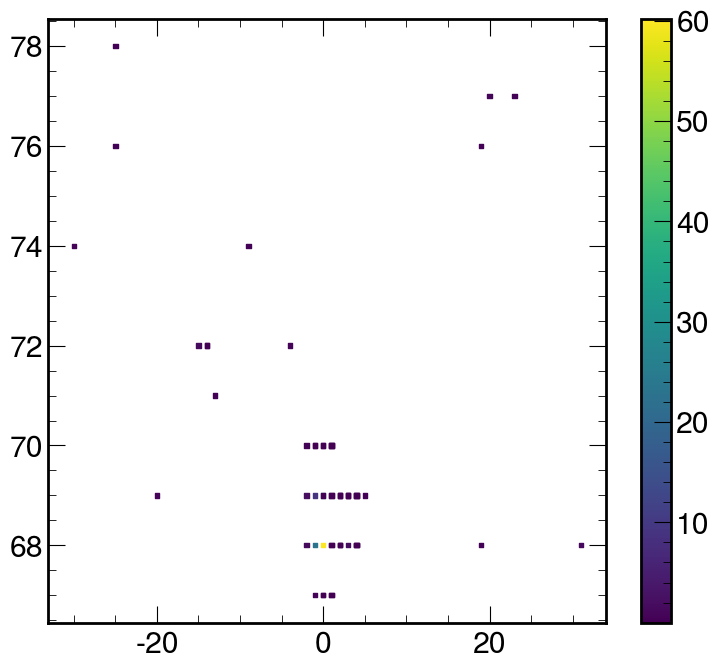

In [20]:
f, ax = plt.subplots(1,1,dpi=100, figsize=(9,8))
a = ax.scatter(rechit_iphi, rechit_ieta, c=rechit_en, marker="s", s=10)
plt.colorbar(a)

In [84]:
df[1]["cl_h"][:,:,3].shape

TensorShape([14, None])